# Занятие 7.1. Временные ряды, ARMA/ARIMA модели

Артем Языков, МФТИ
23.11.2017

In [5]:
# нужные библиотеки
import sys

import pandas as pd
# pip install pandas-datareader

import pandas_datareader.data as web # extract data from various Internet sources into a pandas DataFrame
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


# pip install arch
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl


C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# проверим версию питона
p = print

p(sys.version)

3.6.1 |Anaconda 4.4.0 (64-bit)| (default, May 11 2017, 13:25:24) [MSC v.1900 64 bit (AMD64)]


In [79]:
# если графики не рисуются
%matplotlib inline

## Сбор данных

Скачаем биржевые курсы акций нескольких компаний

In [80]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})

Сразу вычислим логарифмы изменений

In [81]:
# log returns
lrets = np.log(data/data.shift(1)).dropna()

# Визуальное представление рядов

In [82]:
# полезная функция для построения основных графиков
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        # mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

## Попробуем увидеть белый шум

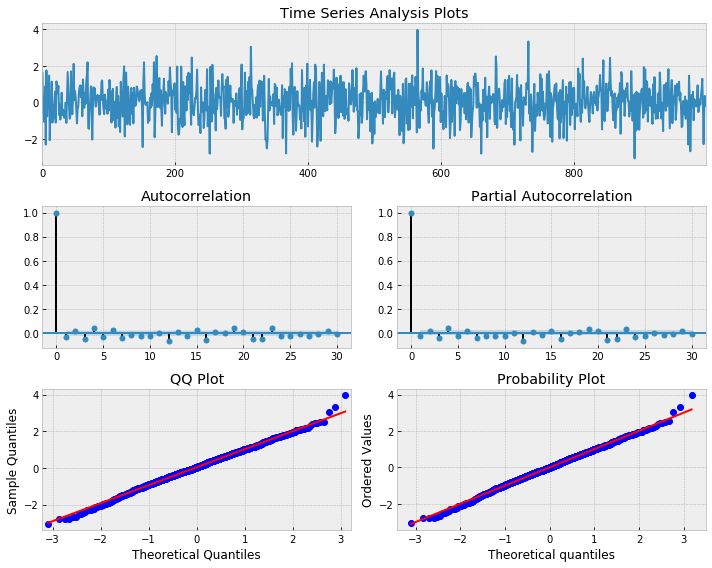

In [83]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [84]:
p("Random Series\n -------------\n mean: {:.3f}\n variance: {:.3f}\n standard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

Random Series
 -------------
 mean: 0.039
 variance: 0.962
 standard deviation: 0.981


## Random walk

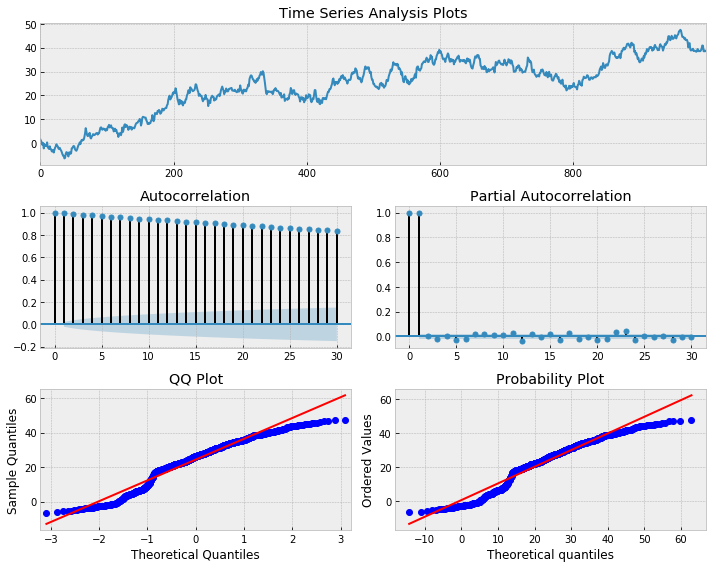

In [85]:
np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

Первая разность случайной прогулки

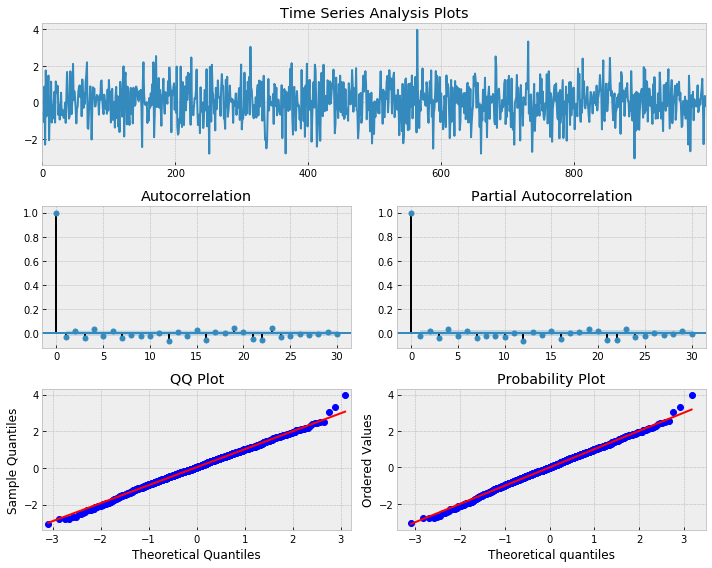

In [86]:
tsplot(np.diff(x), lags=30)

Разность курсов акций SPY

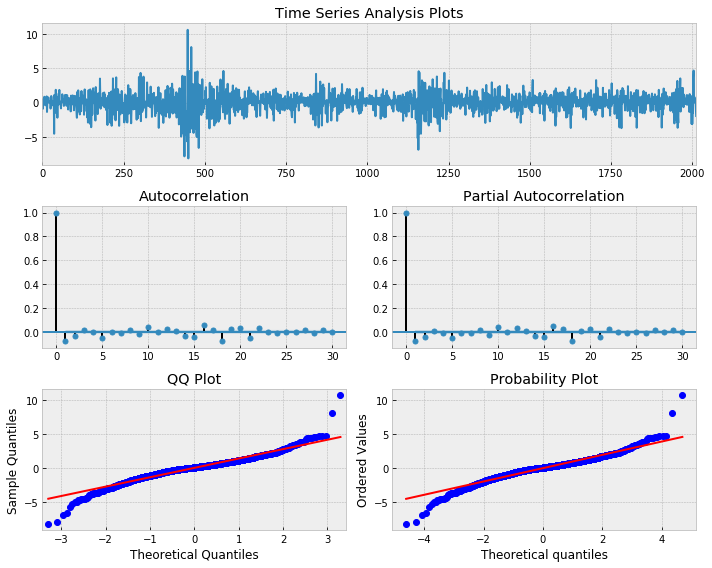

In [87]:
tsplot(np.diff(data.SPY), lags=30)

## Симуляция линейного тренда

In [88]:
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1 * t + w[t]

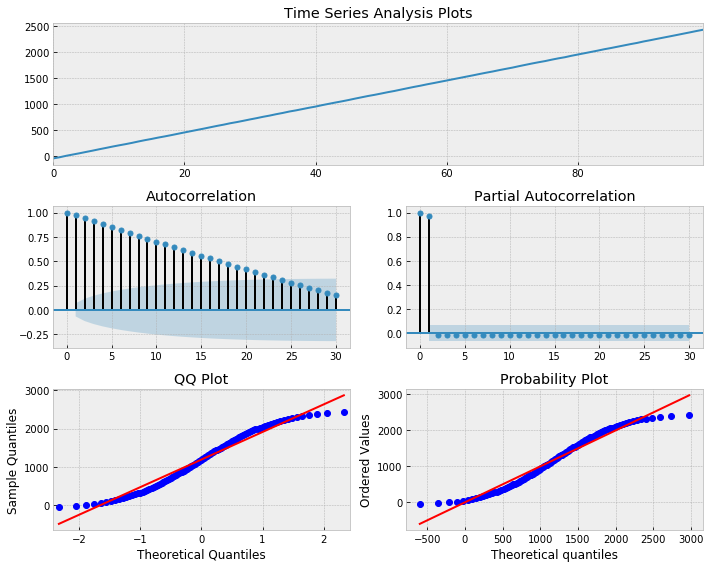

In [89]:
tsplot(y, lags=30)

## Симуляция экспоненциального роста 

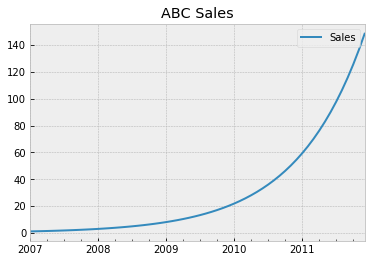

In [90]:
# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

ABC log sales

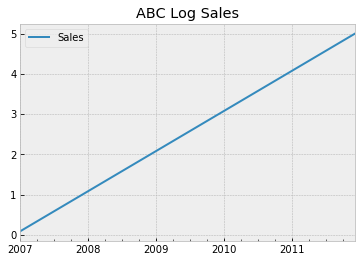

In [91]:
df_2 = np.log(df)

with plt.style.context('bmh'):
    df_2.plot()
    plt.title('ABC Log Sales')

# Симуляция AR(1) процесса

In [92]:
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a * x[t - 1] + w[t]

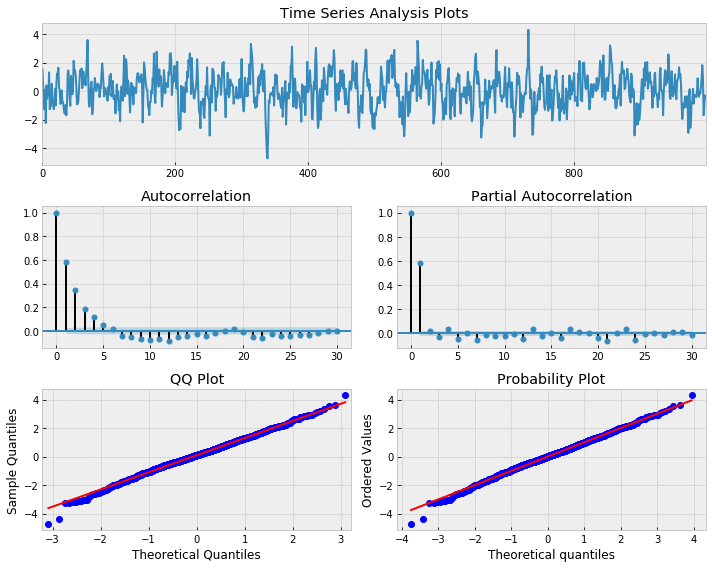

In [93]:
tsplot(x, lags=30)

## Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

In [94]:
mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')

est_order = smt.AR(x).select_order( maxlag=30, ic='aic', trend='nc')

true_order = 1

In [95]:
p('\nalpha estimate: {:3.5f} | best lag order = {}'
  .format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'
  .format(a, true_order))


alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


# Симуляция AR(2) процесса

In [96]:
n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

Python requires us to specify the zero-lag value which is 1
Also note that the alphas for the AR model must be negated
We also set the betas for the MA equal to 0 for an AR(p) model
For more information see the examples at statsmodels.org

In [97]:
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

In [98]:
ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)

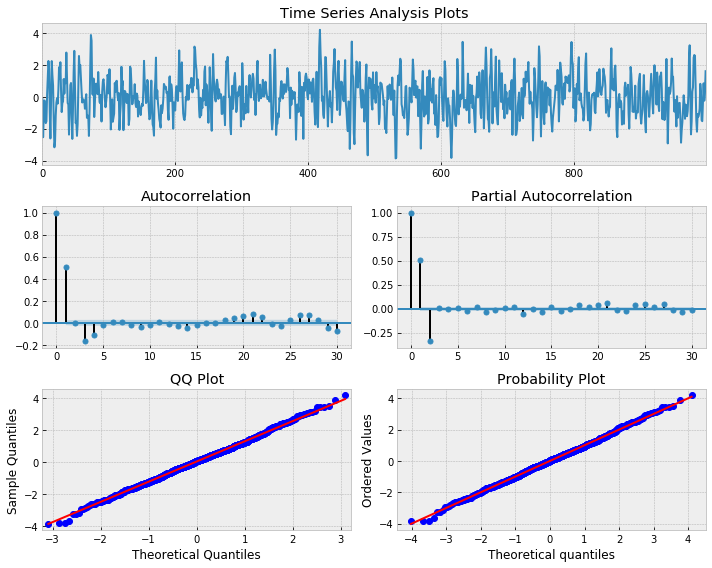

In [99]:
tsplot(ar2, lags=30)

## Fit an AR(p) model to simulated AR(2) process

In [100]:
max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order( maxlag=max_lag, ic='aic', trend='nc')

true_order = 2

In [101]:
p('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'
  .format(mdl.params[0], mdl.params[1], est_order))
p('\ntrue coefs = {} | true order = {}'
  .format([.666, -.333], true_order))


coef estimate: 0.6760 -0.3393 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


# Найдем оптимальный порядок лага для MSFT

In [102]:
max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order( maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))

best estimated lag order = 23


# Симуляция MA(1) процесса

In [103]:
n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

In [104]:
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

In [105]:
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)

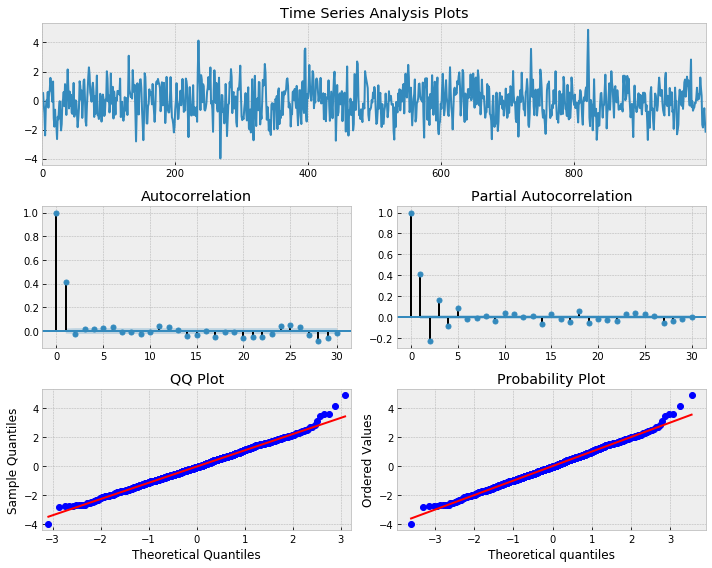

In [106]:
tsplot(ma1, lags=30)

## Найдем модель MA(1) для симулированных данных

In [107]:
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.513
Method:                           mle   S.D. of innovations              0.972
Date:                Thu, 23 Nov 2017   AIC                           2785.025
Time:                        19:52:06   BIC                           2794.841
Sample:                             0   HQIC                          2788.756
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5874      0.026     22.762      0.000       0.537       0.638
                                    Roots                                    
                 Real           Imaginary           M

## Симулируем MA(3) процесс с коэффициентами 0.6, 0.4, 0.2

In [108]:
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

In [109]:
ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)

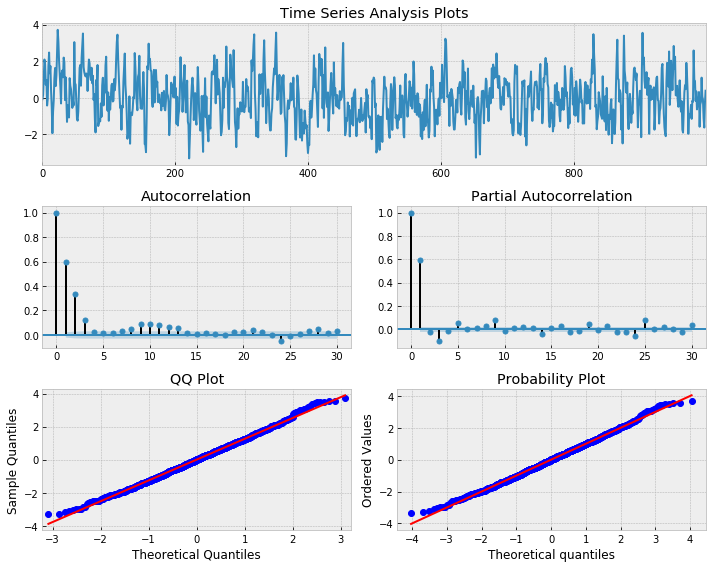

In [110]:
tsplot(ma3, lags=30)

## Найдем MA(3) модель для симулированных данных

In [111]:
max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.038
Method:                           mle   S.D. of innovations              1.008
Date:                Thu, 23 Nov 2017   AIC                           2862.075
Time:                        19:52:11   BIC                           2881.706
Sample:                             0   HQIC                          2869.536
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6025      0.031     19.322      0.000       0.541       0.664
ma.L2.y        0.4060      0.034     11.806      0.000       0.339       0.473
ma.L3.y        0.1683      0.031      5.420      0.0

## Fit MA(3) to SPY returns

In [112]:
max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2013
Model:                     ARMA(0, 3)   Log Likelihood                5756.953
Method:                           mle   S.D. of innovations              0.014
Date:                Thu, 23 Nov 2017   AIC                         -11505.906
Time:                        19:52:12   BIC                         -11483.476
Sample:                    01-04-2007   HQIC                        -11497.673
                         - 12-31-2014                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0959      0.022     -4.314      0.000      -0.139      -0.052
ma.L2.SPY     -0.0737      0.023     -3.256      0.001      -0.118      -0.029
ma.L3.SPY      0.0274      0.022      1.260      0.2

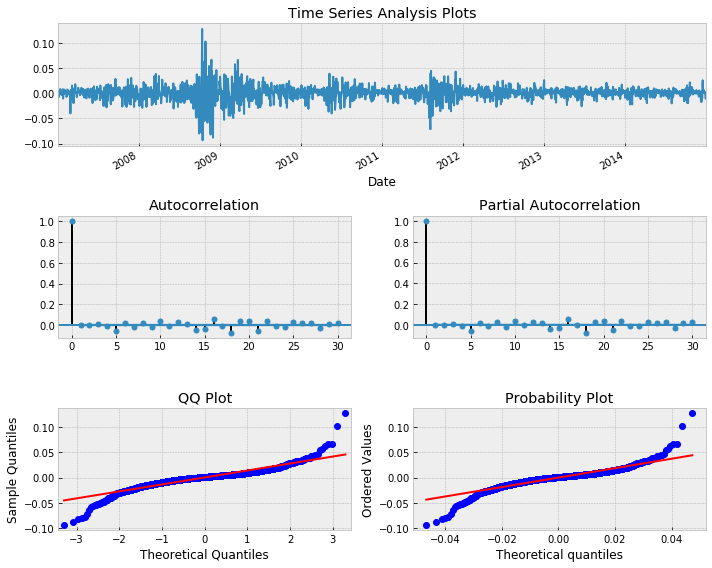

In [113]:
tsplot(mdl.resid, lags=max_lag)

# Симуляция модели ARMA(2, 2) с коэффициентами alphas=[0.5,-0.25] и betas=[0.5,-0.3]

In [114]:
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]


In [115]:
arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)

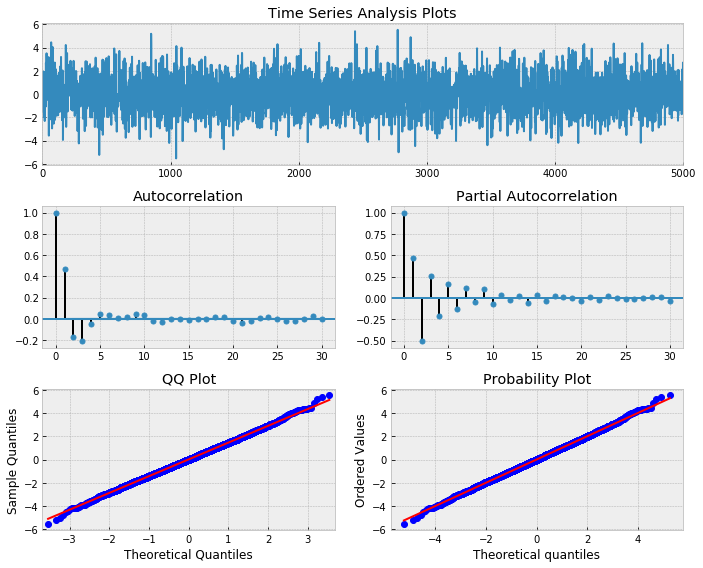

In [116]:
tsplot(arma22, lags=max_lag)

In [117]:
mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7076.176
Method:                           mle   S.D. of innovations              0.996
Date:                Thu, 23 Nov 2017   AIC                          14162.352
Time:                        19:52:18   BIC                          14194.938
Sample:                             0   HQIC                         14173.773
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4730      0.051      9.338      0.000       0.374       0.572
ar.L2.y       -0.2645      0.015    -17.489      0.000      -0.294      -0.235
ma.L1.y        0.5224      0.052     10.089      0.0

# Симуляция модели ARMA(3, 2) с коэффициентами alphas=[0.5,-0.25,0.4] и betas=[0.5,-0.3]

In [118]:
max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

In [119]:
arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)

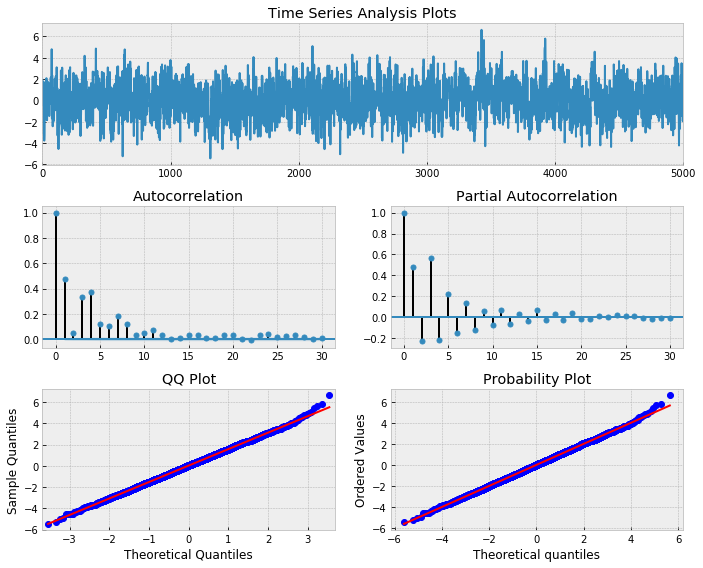

In [120]:
tsplot(arma32, lags=max_lag)

Подберем оптимальный порядок по AIC. Чем он меньше, тем лучше.

In [121]:
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue
            
p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 14212.01026 | order: (3, 2)


# Применение ARMA модели к акциям SPY

In [122]:
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: -11518.23143 | order: (4, 4)


C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# Применение модели ARIMA(p, d, q) к акциям SPY

Подберем оптимальнй порядок и конечную модель по AIC.

In [123]:
best_aic = np.inf
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retval

aic: -11518.23143 | order: (4, 0, 4)


## График невязки (ошибки) модели ARIMA

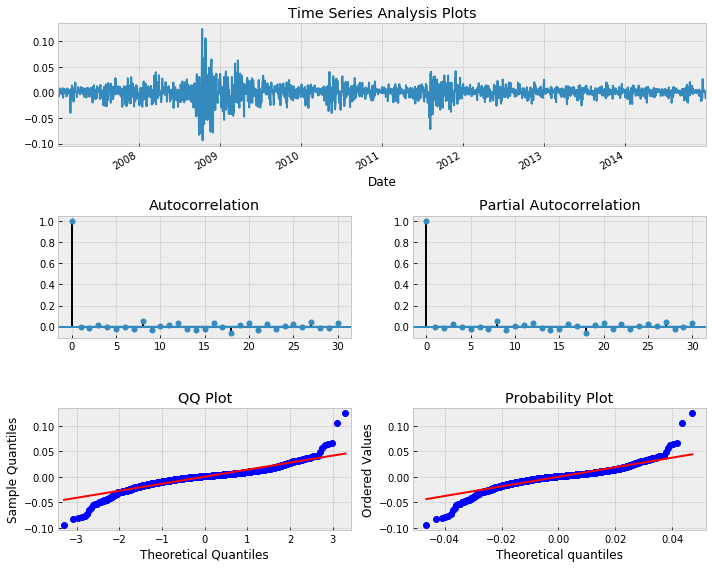

In [124]:
tsplot(best_mdl.resid, lags=30)

## Прогноз курса акций SPY на 21 день

Построим прогноз на уровнях значимости 95% и 99%

In [125]:
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2014-12-31,0.001318,-0.025693,-0.034180,0.028328,0.036816
2015-01-01,-0.000036,-0.027167,-0.035692,0.027094,0.035619
2015-01-02,0.000425,-0.026749,-0.035287,0.027599,0.036138
2015-01-03,0.000642,-0.026533,-0.035071,0.027816,0.036354
2015-01-04,-0.000408,-0.027584,-0.036124,0.026768,0.035308


График прогноза на на 21 день

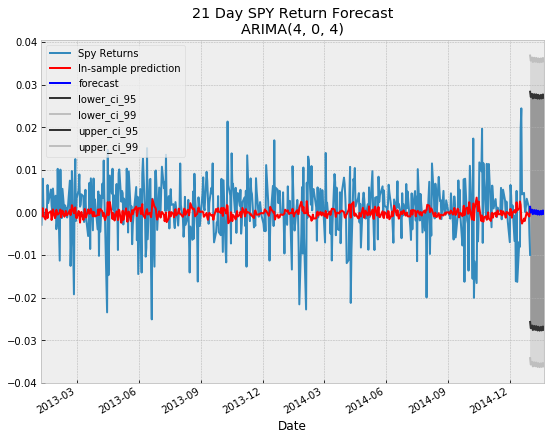

In [126]:
plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

# Симуляция ряда ARCH(1)

Var(yt) = a_0 + a_1*y{t-1}^2

Если a_1 между 0 и 1, то y{t} - белый шум

In [127]:
np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

Симулированный ряд ARCH(1) выглядит как белый шум

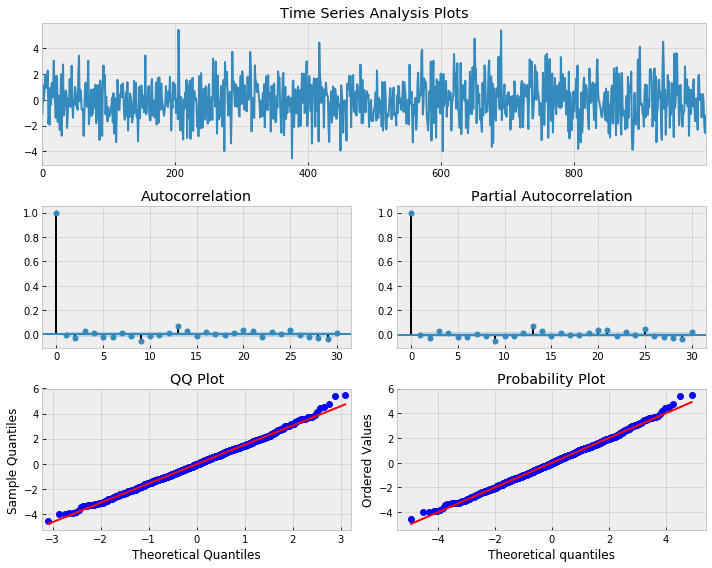

In [128]:
tsplot(Y, lags=30)

# Симуляция процесса GARCH(1, 1)

In [129]:
np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

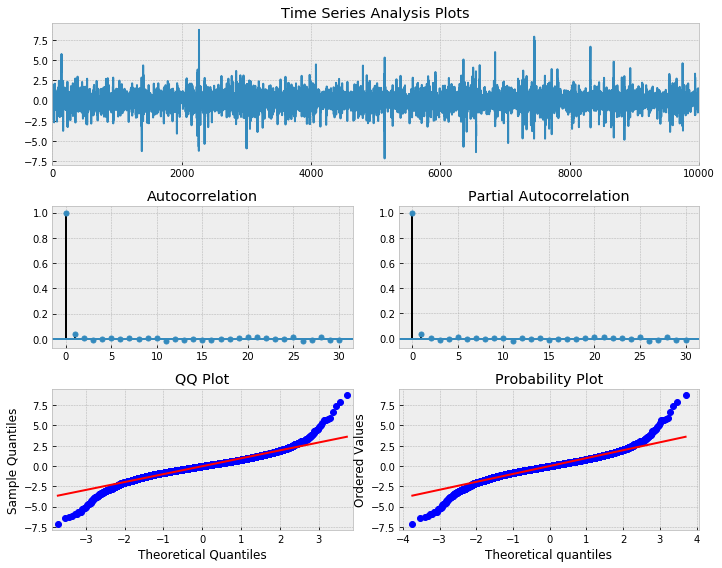

In [130]:
tsplot(eps, lags=30)

## Применение модели GARCH(1, 1) к симулированному ряду eps

Используем функцию arch_model() из библиотеки arch

In [131]:
am = arch_model(eps)
res = am.fit(update_freq=5)
p(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592659128462
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.303267318555
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Thu, Nov 23 2017   Df Residuals:                     9996
Time:      

In [132]:
# функция для подбора оптимальной модели
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

Подберем модель ARIMA для конкретного промежутка времени

In [133]:
TS = lrets.SPY.ix['2012':'2015']
res_tup = _get_best_model(TS)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Users\andre\Anaconda3\lib\site-packages\statsm

aic: -5255.56848 | order: (3, 0, 2)


C:\Users\andre\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


С использованием коэффициентов модели ARIMA теперь мы можем подобрать модель ARCH

In [134]:
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# T-распределение (Стьюдента) обычно дает лучшие модели
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:                2670.80
Distribution:      Standardized Student's t   AIC:                          -5319.61
Method:                  Maximum Likelihood   BIC:                          -5268.73
                                              No. Observations:                  754
Date:                      Thu, Nov 23 2017   Df Residuals:                      743
Time:                              19:54:37   Df Model:                           11
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  